# Lane Detection and Classification using Cascaded CNNs - Inference Code

First of all, we are going to load the basic components, i.e. the required libraries (including pytorch) and our CNN models.

In [9]:
import torch
import torchvision
import numpy as np
import random
import math

# Data loading and visualization imports
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib.pyplot import imshow, figure, subplots

# Model loading
from models.erfnet import Net as ERFNet
from models.lcnet import Net as LCNet

# utils
from functions import color_lanes, blend

# to cuda or not to cuda
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    

We can also define some constants. In this example, we are using 64x64 descriptors, a maximum of 5 classes for the instance segmentation network (0=background + 4 lanes) and 3 classes (continuous, dashed, double-dashed).

In [10]:
# Descriptor size definition
DESCRIPTOR_SIZE = 64

# Maximum number of lanes the network has been trained with + background
NUM_CLASSES_SEGMENTATION = 5

# Maxmimum number of classes for classification
NUM_CLASSES_CLASSIFICATION = 3

# Image size
HEIGHT = 360
WIDTH = 640

Now we load the data for the example. We load the image, visualize it, resize it and build a minibatch of size 1x3x360x640 that will be forwarded to the CNN.

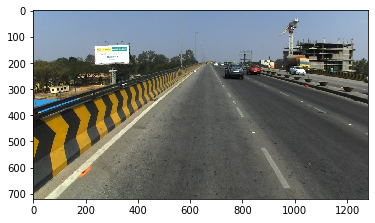

In [11]:
# im = Image.open('images/test.jpg')
im = Image.open('/aimldl-dat/samples/lanenet/4.jpg')
# ipynb visualization
%matplotlib inline
imshow(np.asarray(im))

im = im.resize((WIDTH, HEIGHT))

im_tensor = ToTensor()(im)
im_tensor = im_tensor.unsqueeze(0)

We also need to load the weights of the CNNs. We simply load it using pytorch methods.

In [12]:
# Creating CNNs and loading pretrained models
segmentation_network = ERFNet(NUM_CLASSES_SEGMENTATION)
classification_network = LCNet(NUM_CLASSES_CLASSIFICATION, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)

segmentation_network.load_state_dict(torch.load('pretrained/erfnet_tusimple.pth', map_location = map_location))
model_path = 'pretrained/classification_{}_{}class.pth'.format(DESCRIPTOR_SIZE, NUM_CLASSES_CLASSIFICATION)
    classification_network.load_state_dict(torch.load(model_path, map_location = map_location))

segmentation_network = segmentation_network.eval()
classification_network = classification_network.eval()

if torch.cuda.is_available():
    segmentation_network = segmentation_network.cuda()
    classification_network = classification_network.cuda()

Now: we forward the image to the instance segmentation network and extract an instance segmentation map. In this way, we will have a 360x640 image, where nonzero pixels represent different lane boundaries.

In [13]:
# Inference on instance segmentation
if torch.cuda.is_available():
    im_tensor = im_tensor.cuda()

out_segmentation = segmentation_network(im_tensor)
out_segmentation = out_segmentation.max(dim=1)[1]


In order to evaluate the instance segmentation quality, we can visualize it. The `color_lanes` method is used to map each lane instance index `i` to a random color. It is defined in `functions.py`.

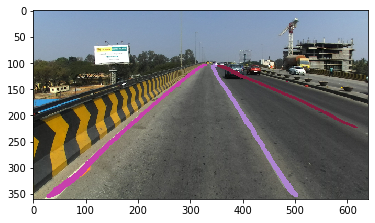

In [14]:
# Converting to numpy for visualization
out_segmentation_np = out_segmentation.cpu().numpy()[0]
out_segmentation_viz = np.zeros((HEIGHT, WIDTH, 3))

for i in range(1, NUM_CLASSES_SEGMENTATION):
    rand_c1 = random.randint(1, 255)
    rand_c2 = random.randint(1, 255)    
    rand_c3 = random.randint(1, 255)
    out_segmentation_viz = color_lanes(
        out_segmentation_viz, out_segmentation_np, 
        i, (rand_c1, rand_c2, rand_c3), HEIGHT, WIDTH)

im_seg = blend(im, out_segmentation_viz)
imshow(np.asarray(im_seg))


Now the core method for descriptor extraction. First of all, the lane boundary instances points are extracted. Then, the 2d image is transformed in its 1d representation using the `view()` method. In this way, it is possible to apply `nonzero()` and extract all the 1d coordinates relative to the single lane boundary. Finally, `DESCRIPTOR_SIZExDESCRIPTOR_SIZE` points are sampled using `uniform_`. In this way, for each lane a representation of a fixed size is extracted, and the appearance of lane markings is preserved. 

The `mapper` object is needed because the instance segmentation network could output non-contiguous ids. For example, if we had three lanes, we could have as outputs classes 1, 2 and 4. So, `mapper` maps the real lane boundary id to a contiguous one.

In [15]:
def extract_descriptors(label, image):
    # avoids problems in the sampling
    eps = 0.01
    
    # The labels indices are not contiguous e.g. we can have index 1, 2, and 4 in an image
    # For this reason, we should construct the descriptor array sequentially
    inputs = torch.zeros(0, 3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        
    # This is needed to keep track of the lane we are classifying
    mapper = {}
    classifier_index = 0
    
    # Iterating over all the possible lanes ids
    for i in range(1, NUM_CLASSES_SEGMENTATION):
        # This extracts all the points belonging to a lane with id = i
        single_lane = label.eq(i).view(-1).nonzero().squeeze()
        
        # As they could be not continuous, skip the ones that have no points
        if single_lane.numel() == 0:
            continue
        
        # Points to sample to fill a squared desciptor
        sample = torch.zeros(DESCRIPTOR_SIZE * DESCRIPTOR_SIZE)
        if torch.cuda.is_available():
            sample = sample.cuda()
            
        sample = sample.uniform_(0, single_lane.size()[0] - eps).long()
        sample, _ = sample.sort()
        
        # These are the points of the lane to select
        points = torch.index_select(single_lane, 0, sample)
        
        # First, we view the image as a set of ordered points
        descriptor = image.squeeze().view(3, -1)
        
        # Then we select only the previously extracted values
        descriptor = torch.index_select(descriptor, 1, points)
        
        # Reshape to get the actual image
        descriptor = descriptor.view(3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
        descriptor = descriptor.unsqueeze(0)
        
        # Concatenate to get a batch that can be processed from the other network
        inputs = torch.cat((inputs, descriptor), 0)
        
        # Track the indices
        mapper[classifier_index] = i
        classifier_index += 1
        
    return inputs, mapper


descriptors, index_map = extract_descriptors(out_segmentation, im_tensor)

Let's visualize the descriptors. As you can see, some sort of pattern is easily recognizable. This is the information that the second CNN has learnt to recognize.

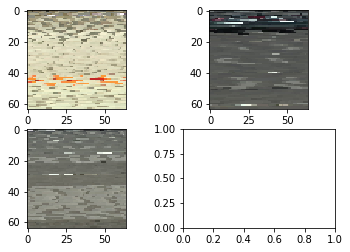

In [16]:
GRID_SIZE = 2
_, fig = subplots(GRID_SIZE, GRID_SIZE)

for i in range(0, descriptors.size(0)):
    desc = descriptors[i].cpu()

    desc = ToPILImage()(desc)
    row = math.floor((i / GRID_SIZE))
    col = i % GRID_SIZE

    fig[row, col].imshow(np.asarray(desc))

We then use the second neural network to process the minibatch of descriptors. The classes are obtained with the usual argmax function.

In [17]:
# Inference on descriptors
classes = classification_network(descriptors).max(1)[1]
print(index_map)
print(classes)

{0: 1, 1: 2, 2: 4}
tensor([0, 1, 1], device='cuda:0')


It is then possible to visualize the classification. Red lanes are continuous, green dashed and blue double-dashed. 

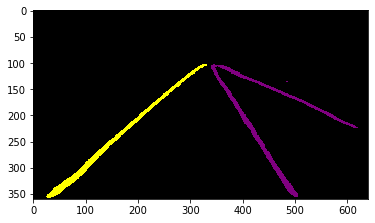

In [18]:
# Class visualization
out_classification_viz = np.zeros((HEIGHT, WIDTH, 3))

for i, lane_index in index_map.items():
    if classes[i] == 0: # Continuous
        color = (255,255,0)
    elif classes[i] == 1: # Dashed
        color = (128,0,128)
    elif classes[i] == 2: # Double-dashed
        color = (0, 0, 255)
    else:
        raise
    out_classification_viz[out_segmentation_np == lane_index] = color

imshow(out_classification_viz.astype(np.uint8))
